In [2]:
import re

import numpy as np
import pandas as pd
from numpy import sort
from scipy.cluster import hierarchy
from scipy.stats import spearmanr

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

import seaborn as sns
import shap
import statsmodels.api as sm

%matplotlib inline
%config InlineBackend.figure_format ='retina'
import statsmodels.stats.api as sms
import xgboost
from sklearn import datasets, metrics, model_selection, preprocessing
from sklearn.ensemble import (
    BaggingClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    StackingClassifier,
    VotingClassifier,
)


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score
)
from sklearn.metrics import *
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    RepeatedKFold,
    cross_val_predict,
    cross_val_score,
    cross_validate,
    learning_curve,
    train_test_split,
    validation_curve,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
from skopt.plots import plot_convergence

sns.set_style("darkgrid")
sns.mpl.rcParams["figure.figsize"] = (15.0, 9.0)

import warnings

import matplotlib
import matplotlib.pyplot as plt

warnings.simplefilter(action="ignore", category=FutureWarning)
from warnings import filterwarnings
warnings.filterwarnings('ignore')

filterwarnings("ignore")

seed = 0

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from keras.layers import LeakyReLU
from keras.optimizers import *
from keras.utils import np_utils
from keras import regularizers


In [17]:
data = pd.read_csv("training_cleaned.csv", header=0, sep=",")

In [18]:
data['BPlabel_encoded'] = data['BPlabel'].map( {'most likely':0,'probable':1, 'least likely':2})
Y = data["BPlabel_encoded"] 
data = data.drop(["BPlabel"],1)
data.shape 

(293, 61)

In [19]:
X = pd.read_csv("selected_features_training_data.csv", header=0)
X.columns = [
    regex.sub("_", col) if any(x in str(col) for x in set(("[", "]", "<"))) else col
    for col in X.columns.values
]

X = MinMaxScaler().fit_transform(X)

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

In [28]:
X.shape[1]

10

In [6]:
def baseline_model(optimizer='SGD', learning_rate=0.01, momentum=0, activation='relu', dropout_rate=0.0, weight_constraint=0, neurons=1):
    model = Sequential()
    model.add(Dense(neurons, input_dim=101, activation=activation)) #dense layers perform: output = activation(dot(input, kernel) + bias).
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation=activation)) #8 is the dim/ the number of hidden units (units are the kernel)
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

keras = KerasClassifier(build_fn=baseline_model, batch_size=32, epochs=10, verbose=0)

optimizer = ['SGD','RMSprop','adam']
activation = ['softmax', 'relu', 'tanh'] 
lr_rate = (0.01, 0.1)
momentum = (0.3, 0.6, 0.9)
dropout_rate = (0.0, 0.1, 0.2)
neurons = (8, 100)
keras_params = dict(optimizer=optimizer, learning_rate=lr_rate, momentum=momentum, activation=activation, 
                    dropout_rate=dropout_rate, neurons=neurons)


inner_cv = KFold(n_splits=5, shuffle=True, random_state=seed)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=seed)

clf = BayesSearchCV(keras, keras_params, cv=inner_cv,iid=False, n_jobs=1)

scoring = ['accuracy', 'balanced_accuracy', 'f1_weighted', 
          'precision_weighted','recall_weighted']

In [61]:
nested_cv_results = cross_validate(clf, X , Y, cv=outer_cv, scoring=scoring, error_score="raise")
nested_cv_results2 = cross_val_score(clf, X , Y, cv=outer_cv, scoring='balanced_accuracy', error_score="raise")

In [62]:
print( 'Nested CV results for all scores:', '\n', nested_cv_results, '\n')
print( 'Accuracy Nested CV Average', np.mean(nested_cv_results['test_accuracy']))
print( 'Balanced Accuracy Nested CV Average', np.mean(nested_cv_results['test_balanced_accuracy'] ))
print( 'F1 Nested CV Average', np.mean(nested_cv_results['test_f1_weighted'] ))
print( 'Precision Nested CV Average', np.mean(nested_cv_results['test_precision_weighted'] ))
print( 'Recall Nested CV Average', np.mean(nested_cv_results['test_recall_weighted'] ))
clf.fit(X_train, Y_train)
print("Best Parameters: \n{}\n".format(clf.best_params_))
print('Non-nested CV Results:')
y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_test)
print( 'Train accuracy:', accuracy_score(Y_train, y_pred_train), 'Test accuracy:', accuracy_score(Y_test, y_pred))
print( 'Train balanced accuracy:', balanced_accuracy_score(Y_train, y_pred_train), 'Test balanced accuracy:', balanced_accuracy_score(Y_test, y_pred))
print( 'Train F1', f1_score(Y_train, y_pred_train, average='weighted'), 'Test F1:', f1_score(Y_test, y_pred, average='weighted'))
print( 'Train recall:', recall_score(Y_train, y_pred_train, average='weighted'),'Test recall:', recall_score(Y_test, y_pred,average='weighted'))
print( 'Train precision:', precision_score(Y_train, y_pred_train,average='weighted'), 'Test precision:', precision_score(Y_test, y_pred,average='weighted'))


Nested CV results for all scores: 
 {'fit_time': array([185.39172292, 182.2099328 , 187.33348203, 168.94764805,
       178.32944679]), 'score_time': array([0.04635215, 0.06495833, 0.05165625, 0.04788494, 0.04854202]), 'test_accuracy': array([0.73469388, 0.59183673, 0.63265306, 0.70833333, 0.60416667]), 'test_balanced_accuracy': array([0.59920635, 0.52380952, 0.50252525, 0.64568765, 0.44197531]), 'test_f1_weighted': array([0.65993921, 0.61482113, 0.63934123, 0.69795322, 0.51177536]), 'test_precision_weighted': array([0.81490271, 0.66016176, 0.65846339, 0.70269564, 0.47371032]), 'test_recall_weighted': array([0.73469388, 0.59183673, 0.63265306, 0.70833333, 0.60416667])} 

Accuracy Nested CV Average 0.6543367346938775
Balanced Accuracy Nested CV Average 0.5426408159741494
F1 Nested CV Average 0.6247660299281103
Precision Nested CV Average 0.661986761565389
Recall Nested CV Average 0.6543367346938775
Best Parameters: 
OrderedDict([('activation', 'tanh'), ('dropout_rate', 0.2), ('learning_r

In [23]:
def baseline_model(optimizer='RMSprop', learning_rate=0.01, momentum=0.9, activation='tanh', dropout_rate=0.2, weight_constraint=0, neurons=160):
    model = Sequential()
    model.add(Dense(neurons, input_dim=10, activation=activation)) #dense layers perform: output = activation(dot(input, kernel) + bias).
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation=activation)) #8 is the dim/ the number of hidden units (units are the kernel)
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


keras = KerasClassifier(build_fn=baseline_model, batch_size=32, epochs=10, verbose=0)

In [24]:
history = keras.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs=100, batch_size=32)

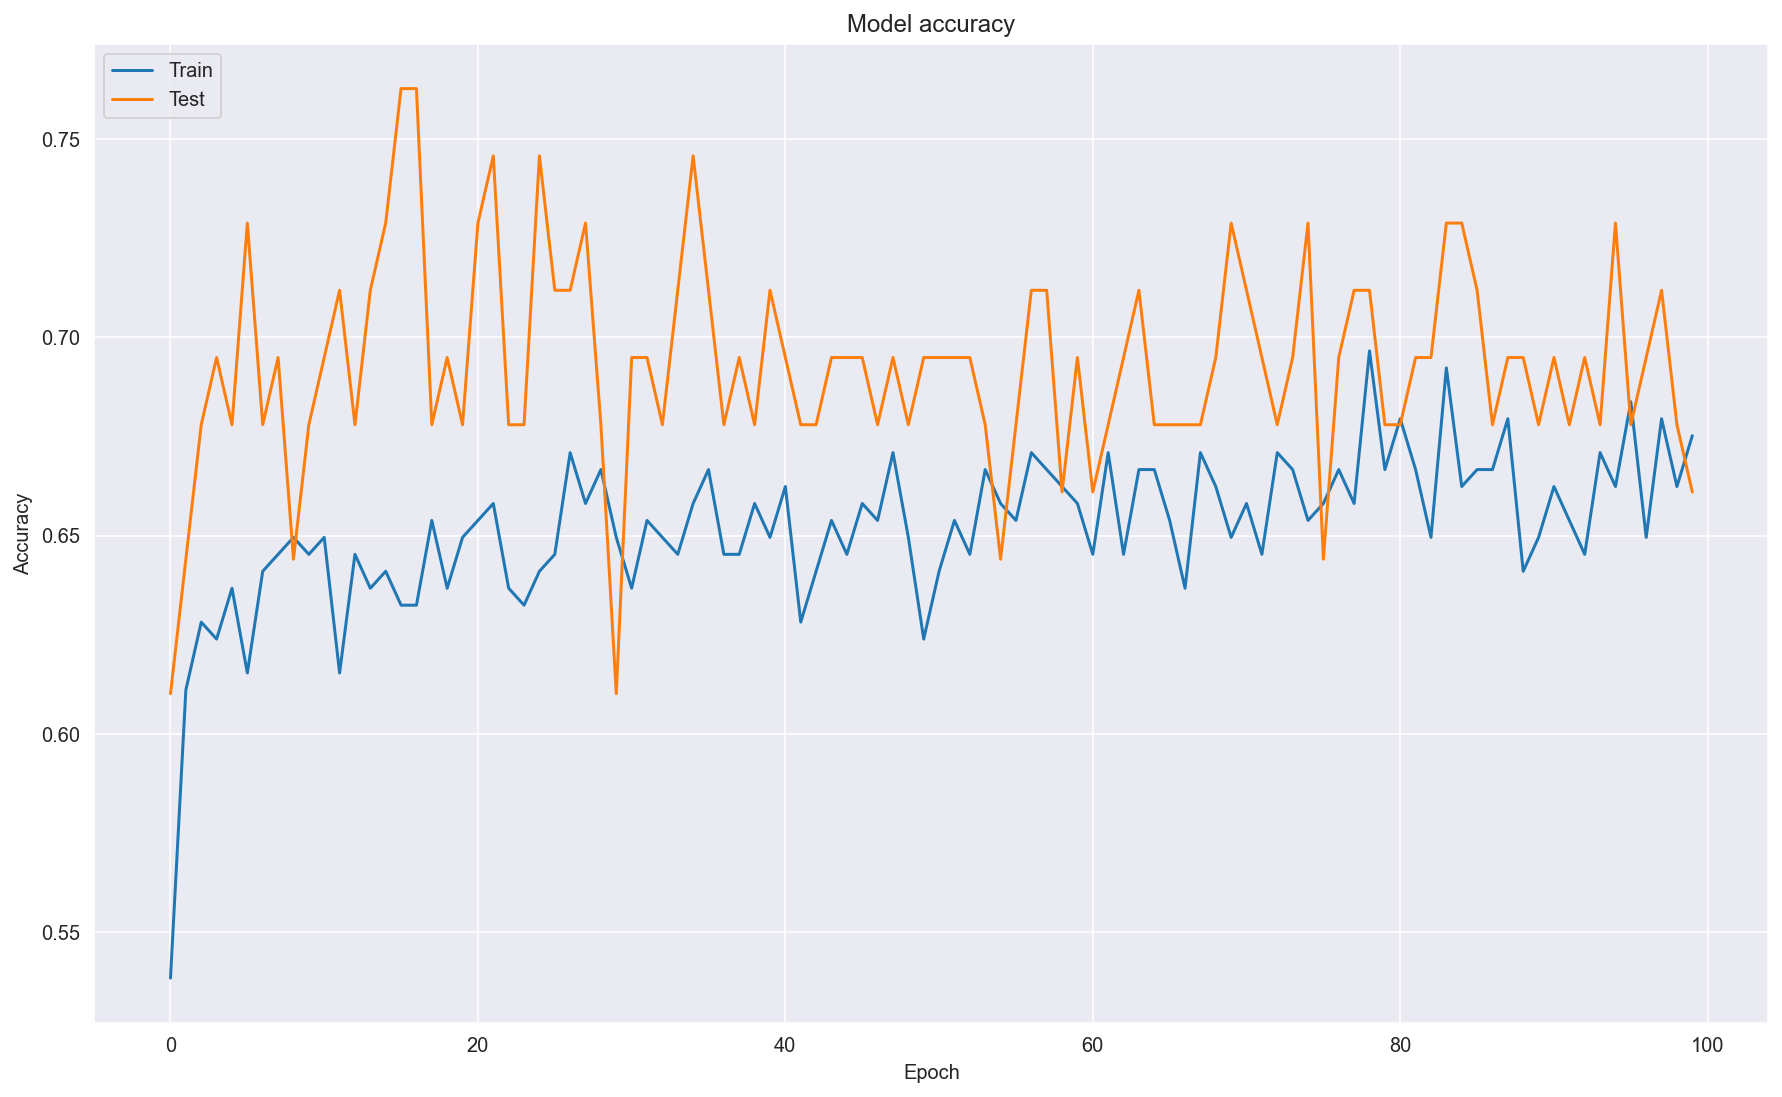

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

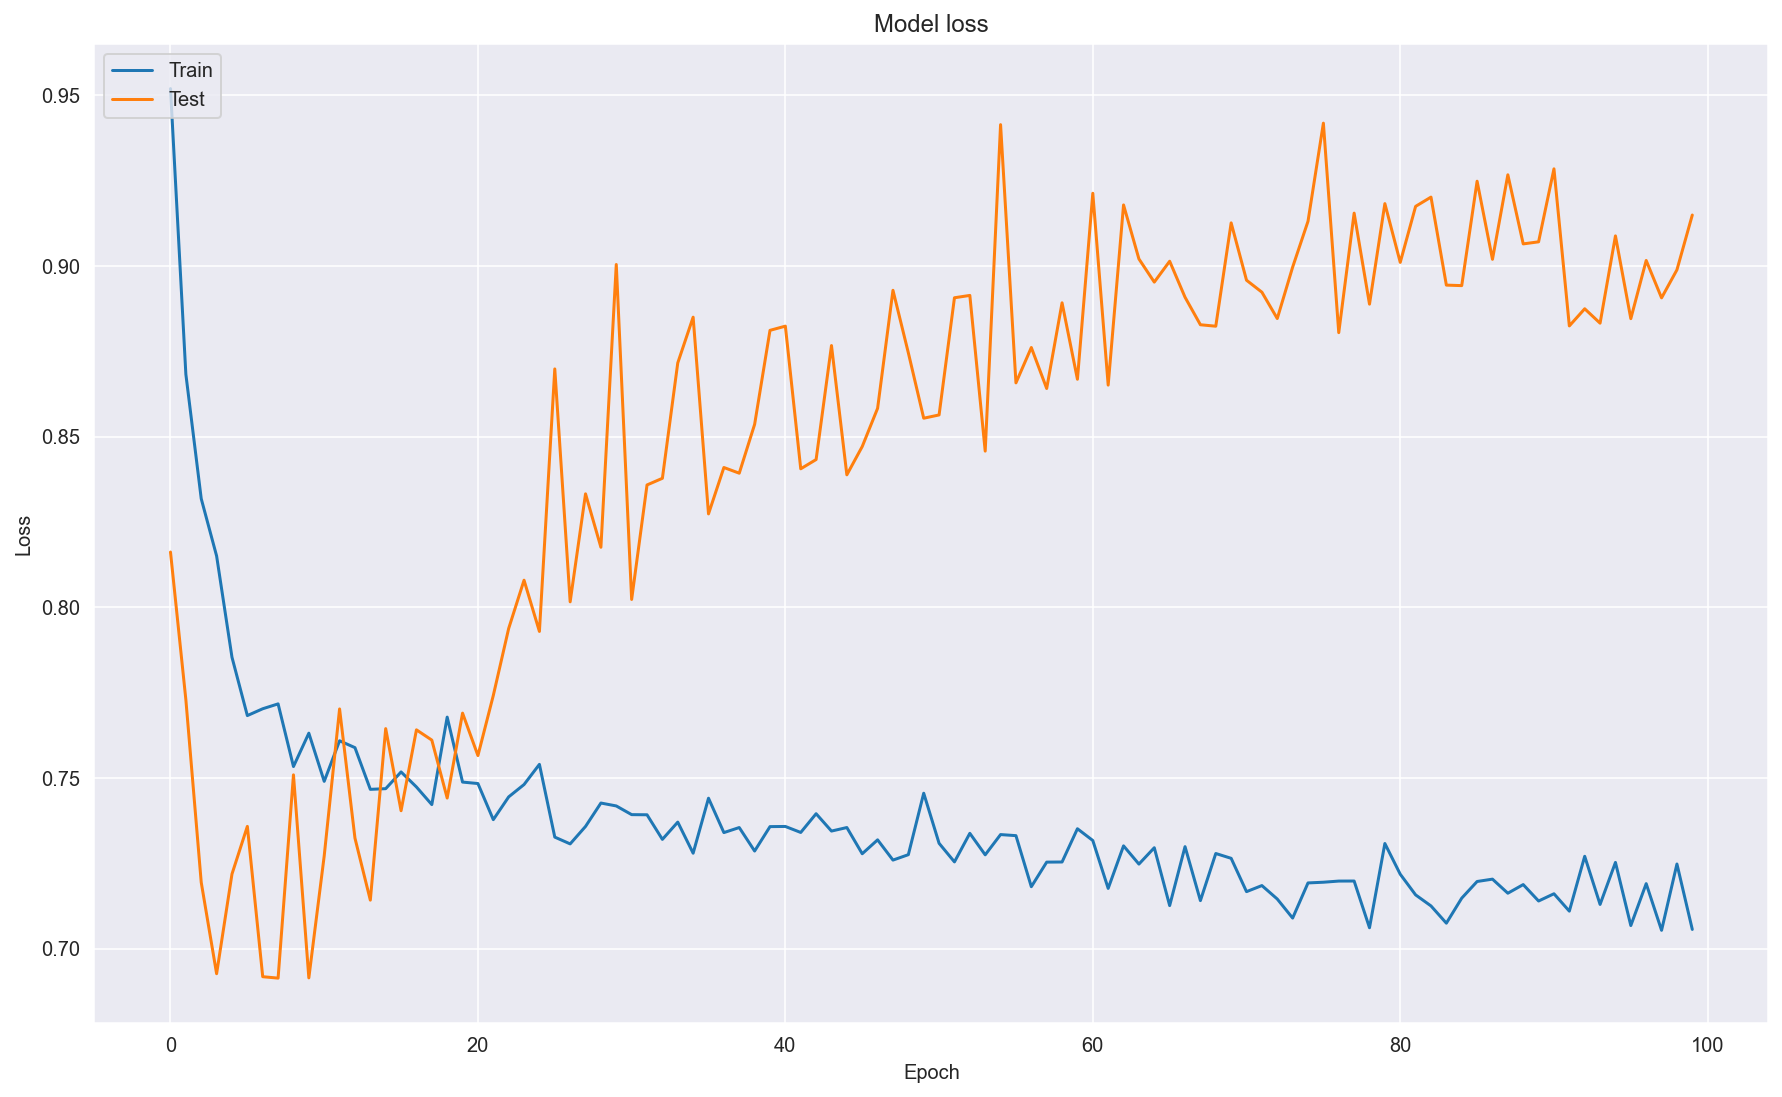

In [26]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [7]:
X_boruta_sel = pd.read_csv("2021-11-19_selected_features_training_data.csv", header=0)
X_boruta_sel.columns = [
    regex.sub("_", col) if any(x in str(col) for x in set(("[", "]", "<"))) else col
    for col in X_boruta_sel.columns.values
]

X_boruta_sel = MinMaxScaler().fit_transform(X_boruta_sel)

In [8]:
def baseline_model(optimizer='SGD', learning_rate=0.01, momentum=0, activation='relu', dropout_rate=0.0, weight_constraint=0, neurons=1):
    model = Sequential()
    model.add(Dense(neurons, input_dim=8, activation=activation)) #dense layers perform: output = activation(dot(input, kernel) + bias).
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation=activation)) #8 is the dim/ the number of hidden units (units are the kernel)
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

keras = KerasClassifier(build_fn=baseline_model, batch_size=32, epochs=10, verbose=0)

optimizer = ['SGD','RMSprop','adam']
activation = ['softmax', 'relu', 'tanh'] 
lr_rate = (0.01, 0.1)
momentum = (0.3, 0.6, 0.9)
dropout_rate = (0.0, 0.1, 0.2)
neurons = (50, 150, 200)
keras_params = dict(optimizer=optimizer, learning_rate=lr_rate, momentum=momentum, activation=activation, 
                    dropout_rate=dropout_rate, neurons=neurons)


inner_cv = KFold(n_splits=5, shuffle=True, random_state=seed)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=seed)

clf = BayesSearchCV(keras, keras_params, cv=inner_cv,iid=False, n_jobs=1)

scoring = ['accuracy', 'balanced_accuracy', 'f1_weighted', 
          'precision_weighted','recall_weighted']

In [8]:
X_train_boruta, X_test_boruta, Y_train_boruta, Y_test_boruta = train_test_split(X_boruta_sel, Y, test_size=0.2, random_state=0)

In [71]:
nested_cv_results = cross_validate(clf, X_boruta_sel , Y, cv=outer_cv, scoring=scoring, error_score="raise")
nested_cv_results2 = cross_val_score(clf, X_boruta_sel , Y, cv=outer_cv, scoring='balanced_accuracy', error_score="raise")

In [72]:
print( 'Nested CV results for all scores:', '\n', nested_cv_results, '\n')
print( 'Accuracy Nested CV Average', np.mean(nested_cv_results['test_accuracy']))
print( 'Balanced Accuracy Nested CV Average', np.mean(nested_cv_results['test_balanced_accuracy'] ))
print( 'F1 Nested CV Average', np.mean(nested_cv_results['test_f1_weighted'] ))
print( 'Precision Nested CV Average', np.mean(nested_cv_results['test_precision_weighted'] ))
print( 'Recall Nested CV Average', np.mean(nested_cv_results['test_recall_weighted'] ))
clf.fit(X_train_boruta, Y_train_boruta)
print("Best Parameters: \n{}\n".format(clf.best_params_))
print('Non-nested CV Results:')
y_pred_train = clf.predict(X_train_boruta)
y_pred = clf.predict(X_test_boruta)
print( 'Train accuracy:', accuracy_score(Y_train_boruta, y_pred_train), 'Test accuracy:', accuracy_score(Y_test_boruta, y_pred))
print( 'Train balanced accuracy:', balanced_accuracy_score(Y_train_boruta, y_pred_train), 'Test balanced accuracy:', balanced_accuracy_score(Y_test_boruta, y_pred))
print( 'Train F1', f1_score(Y_train_boruta, y_pred_train, average='weighted'), 'Test F1:', f1_score(Y_test_boruta, y_pred, average='weighted'))
print( 'Train recall:', recall_score(Y_train_boruta, y_pred_train, average='weighted'),'Test recall:', recall_score(Y_test_boruta, y_pred,average='weighted'))
print( 'Train precision:', precision_score(Y_train_boruta, y_pred_train,average='weighted'), 'Test precision:', precision_score(Y_test_boruta, y_pred,average='weighted'))

Nested CV results for all scores: 
 {'fit_time': array([220.96603179, 204.46651816, 177.46454406, 164.46676517,
       162.83208179]), 'score_time': array([0.05731916, 0.06217003, 0.04924989, 0.05040789, 0.04930425]), 'test_accuracy': array([0.67346939, 0.75510204, 0.79591837, 0.70833333, 0.58333333]), 'test_balanced_accuracy': array([0.59920635, 0.57768158, 0.58333333, 0.62820513, 0.40561167]), 'test_f1_weighted': array([0.65382653, 0.71896058, 0.75843014, 0.69021862, 0.50444935]), 'test_precision_weighted': array([0.64405762, 0.78812013, 0.82303207, 0.70251736, 0.55009921]), 'test_recall_weighted': array([0.67346939, 0.75510204, 0.79591837, 0.70833333, 0.58333333])} 

Accuracy Nested CV Average 0.7032312925170068
Balanced Accuracy Nested CV Average 0.5588076121409455
F1 Nested CV Average 0.6651770438355802
Precision Nested CV Average 0.7015652773159207
Recall Nested CV Average 0.7032312925170068
Best Parameters: 
OrderedDict([('activation', 'relu'), ('dropout_rate', 0.0), ('learning_

In [11]:
def baseline_model(optimizer='adam', learning_rate=0.1, momentum=0.9, activation='relu', dropout_rate=0.0, weight_constraint=0, neurons=91):
    model = Sequential()
    model.add(Dense(neurons, input_dim=8, activation=activation)) #dense layers perform: output = activation(dot(input, kernel) + bias).
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation=activation)) #8 is the dim/ the number of hidden units (units are the kernel)
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


keras = KerasClassifier(build_fn=baseline_model, batch_size=32, epochs=10, verbose=0)


In [74]:
history = keras.fit(X_train_boruta, Y_train_boruta, validation_data = (X_test_boruta, Y_test_boruta), epochs=500, batch_size=32)

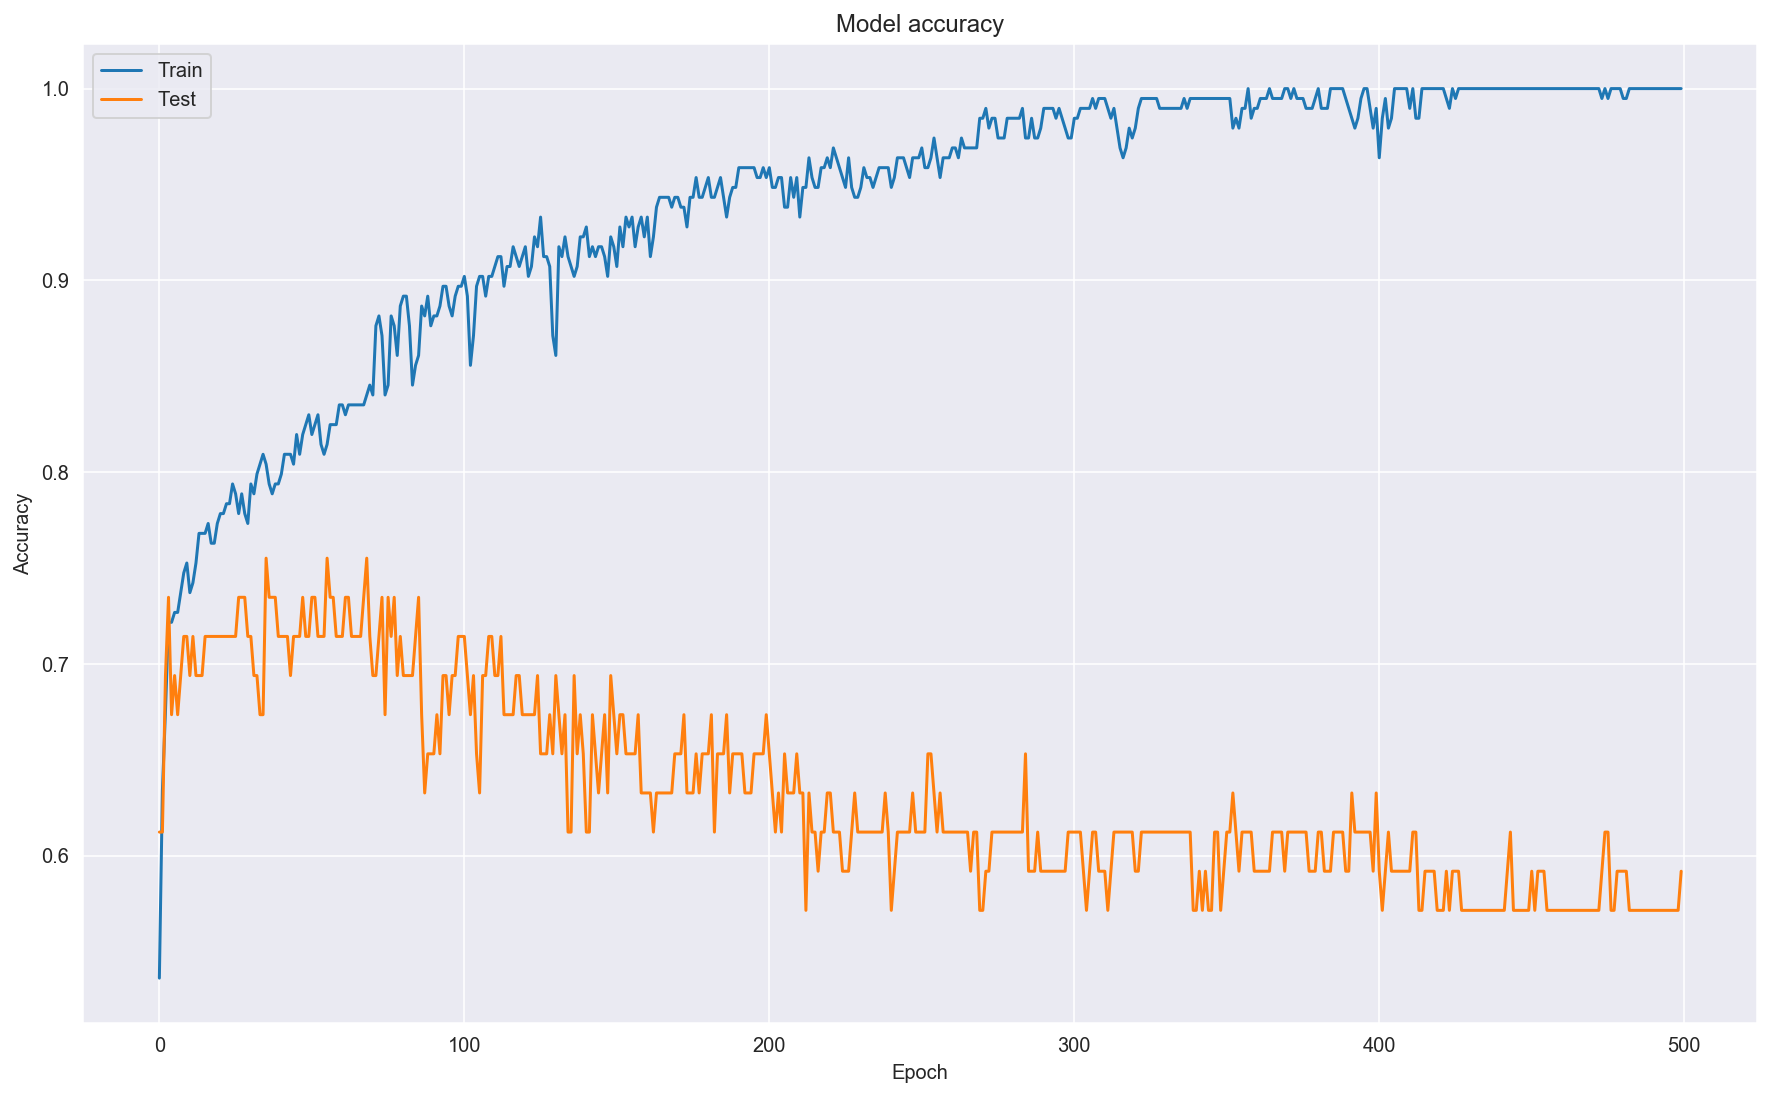

In [75]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

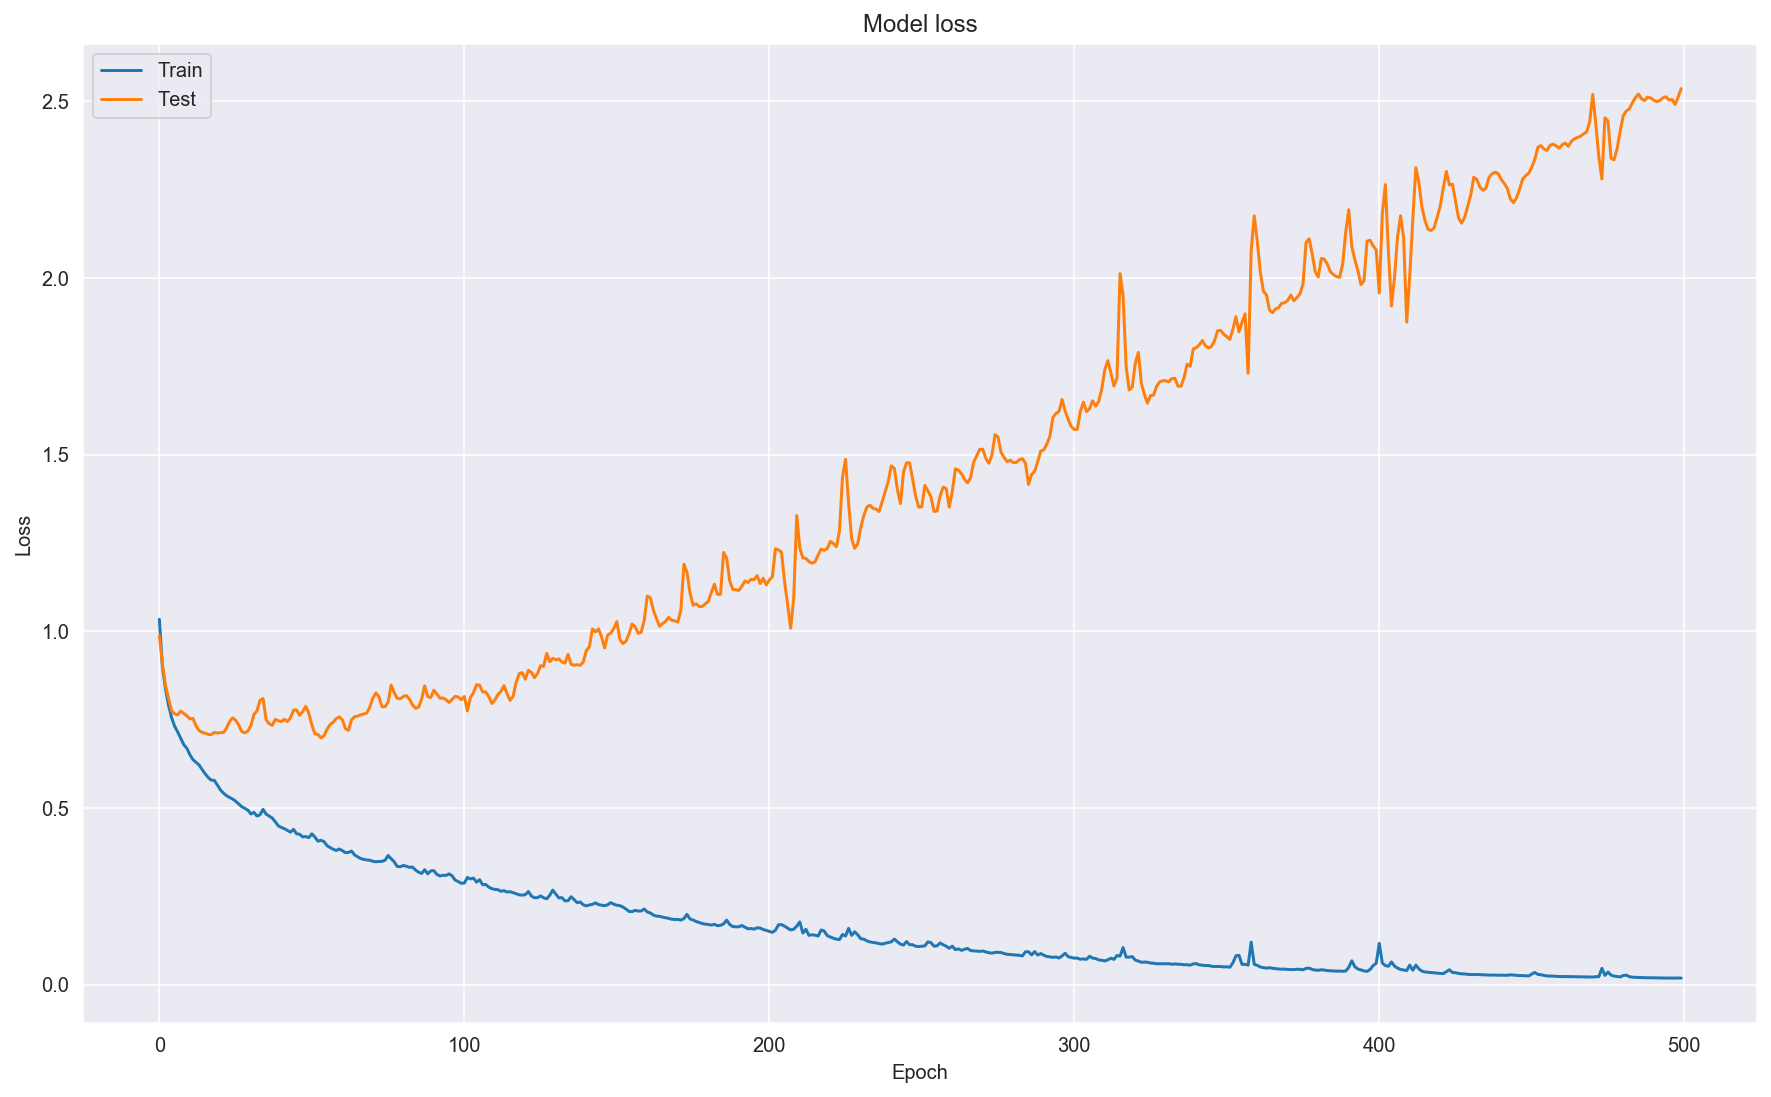

In [76]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [12]:
target_names = ['most likely', 'probable', 'least likely']
keras.fit(X_train_boruta, Y_train_boruta)
predictions = list(keras.predict(X_test_boruta))
print(classification_report(Y_test_boruta, predictions, target_names=target_names))

              precision    recall  f1-score   support

 most likely       0.00      0.00      0.00        12
    probable       0.61      1.00      0.76        30
least likely       0.00      0.00      0.00         7

    accuracy                           0.61        49
   macro avg       0.20      0.33      0.25        49
weighted avg       0.37      0.61      0.46        49



In [9]:
X_boruta_sel = pd.read_csv("2021-11-19_selected_features_training_data.csv", header=0)
X_boruta_sel.columns = [
    regex.sub("_", col) if any(x in str(col) for x in set(("[", "]", "<"))) else col
    for col in X_boruta_sel.columns.values
]

X_boruta_sel = MinMaxScaler().fit_transform(X_boruta_sel)
Y2 = Y

In [10]:
print('Before OverSampling, the shape of X: {}'.format(X_boruta_sel.shape))
print('Before OverSampling, the shape of y: {} \n'.format(Y2.shape))

sm = SMOTE(random_state=seed)
X_boruta_sel, Y2 = sm.fit_resample(X_boruta_sel, Y2)

print('After OverSampling, the shape of X: {}'.format(X_boruta_sel.shape))
print('After OverSampling, the shape of y: {} \n'.format(Y2.shape))

print("After OverSampling, counts of label '1': {}".format(sum(Y2==0)))
print("After OverSampling, counts of label '2': {}".format(sum(Y2==1)))
print("After OverSampling, counts of label '3': {}".format(sum(Y2==2)))

Before OverSampling, the shape of X: (243, 8)
Before OverSampling, the shape of y: (243,) 

After OverSampling, the shape of X: (447, 8)
After OverSampling, the shape of y: (447,) 

After OverSampling, counts of label '1': 149
After OverSampling, counts of label '2': 149
After OverSampling, counts of label '3': 149


In [19]:
def baseline_model(optimizer='SGD', learning_rate=0.01, momentum=0, activation='relu', dropout_rate=0.0, weight_constraint=0, neurons=1):
    model = Sequential()
    model.add(Dense(neurons, input_dim=8, activation=activation)) #dense layers perform: output = activation(dot(input, kernel) + bias).
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation=activation)) #8 is the dim/ the number of hidden units (units are the kernel)
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

keras = KerasClassifier(build_fn=baseline_model, batch_size=32, epochs=10, verbose=0)

optimizer = ['SGD','RMSprop','adam']
activation = ['softmax', 'relu', 'tanh'] 
lr_rate = (0.01, 0.1)
momentum = (0.3, 0.6, 0.9)
dropout_rate = (0.0, 0.1, 0.2)
neurons = (8, 100)
keras_params = dict(optimizer=optimizer, learning_rate=lr_rate, momentum=momentum, activation=activation, 
                    dropout_rate=dropout_rate, neurons=neurons)


inner_cv = KFold(n_splits=5, shuffle=True, random_state=seed)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=seed)

clf = BayesSearchCV(keras, keras_params, cv=inner_cv,iid=False, n_jobs=1)

scoring = ['accuracy', 'balanced_accuracy', 'f1_weighted', 
          'precision_weighted','recall_weighted']

In [11]:
X_train_boruta, X_test_boruta, Y_train_boruta, Y_test_boruta = train_test_split(X_boruta_sel, Y2, test_size=0.2, random_state=0)

In [21]:
nested_cv_results = cross_validate(clf, X_boruta_sel , Y2, cv=outer_cv, scoring=scoring, error_score="raise")
nested_cv_results2 = cross_val_score(clf, X_boruta_sel , Y2, cv=outer_cv, scoring='balanced_accuracy', error_score="raise")

2022-01-11 16:17:59.884562: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
print( 'Nested CV results for all scores:', '\n', nested_cv_results, '\n')
print( 'Accuracy Nested CV Average', np.mean(nested_cv_results['test_accuracy']))
print( 'Balanced Accuracy Nested CV Average', np.mean(nested_cv_results['test_balanced_accuracy'] ))
print( 'F1 Nested CV Average', np.mean(nested_cv_results['test_f1_weighted'] ))
print( 'Precision Nested CV Average', np.mean(nested_cv_results['test_precision_weighted'] ))
print( 'Recall Nested CV Average', np.mean(nested_cv_results['test_recall_weighted'] ))
clf.fit(X_train_boruta, Y_train_boruta)
print("Best Parameters: \n{}\n".format(clf.best_params_))
print('Non-nested CV Results:')
y_pred_train = clf.predict(X_train_boruta)
y_pred = clf.predict(X_test_boruta)
print( 'Train accuracy:', accuracy_score(Y_train_boruta, y_pred_train), 'Test accuracy:', accuracy_score(Y_test_boruta, y_pred))
print( 'Train balanced accuracy:', balanced_accuracy_score(Y_train_boruta, y_pred_train), 'Test balanced accuracy:', balanced_accuracy_score(Y_test_boruta, y_pred))
print( 'Train F1', f1_score(Y_train_boruta, y_pred_train, average='weighted'), 'Test F1:', f1_score(Y_test_boruta, y_pred, average='weighted'))
print( 'Train recall:', recall_score(Y_train_boruta, y_pred_train, average='weighted'),'Test recall:', recall_score(Y_test_boruta, y_pred,average='weighted'))
print( 'Train precision:', precision_score(Y_train_boruta, y_pred_train,average='weighted'), 'Test precision:', precision_score(Y_test_boruta, y_pred,average='weighted'))

Nested CV results for all scores: 
 {'fit_time': array([242.21457791, 200.55895972, 190.15699196, 198.41813135,
       187.28906488]), 'score_time': array([0.07316089, 0.04678226, 0.04844618, 0.04462576, 0.05102801]), 'test_accuracy': array([0.64444444, 0.56666667, 0.71910112, 0.64044944, 0.59550562]), 'test_balanced_accuracy': array([0.63903301, 0.60642228, 0.73385621, 0.64829639, 0.60952153]), 'test_f1_weighted': array([0.65725541, 0.54553459, 0.72292673, 0.64006356, 0.59038742]), 'test_precision_weighted': array([0.68346561, 0.55630848, 0.75520519, 0.64779602, 0.69972109]), 'test_recall_weighted': array([0.64444444, 0.56666667, 0.71910112, 0.64044944, 0.59550562])} 

Accuracy Nested CV Average 0.6332334581772784
Balanced Accuracy Nested CV Average 0.6474258823459719
F1 Nested CV Average 0.6312335425276199
Precision Nested CV Average 0.6684992785154111
Recall Nested CV Average 0.6332334581772784
Best Parameters: 
OrderedDict([('activation', 'relu'), ('dropout_rate', 0.1), ('learning_

In [12]:
def baseline_model(optimizer='RMSprop', learning_rate=0.1, momentum=0.3, activation='relu', dropout_rate=0.1, weight_constraint=0, neurons=91):
    model = Sequential()
    model.add(Dense(neurons, input_dim=8, activation=activation)) #dense layers perform: output = activation(dot(input, kernel) + bias).
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation=activation)) #8 is the dim/ the number of hidden units (units are the kernel)
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


keras = KerasClassifier(build_fn=baseline_model, batch_size=32, epochs=10, verbose=0)


In [13]:
history = keras.fit(X_train_boruta, Y_train_boruta, validation_data = (X_test_boruta, Y_test_boruta), epochs=500, batch_size=32)

2022-01-12 12:27:14.356374: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


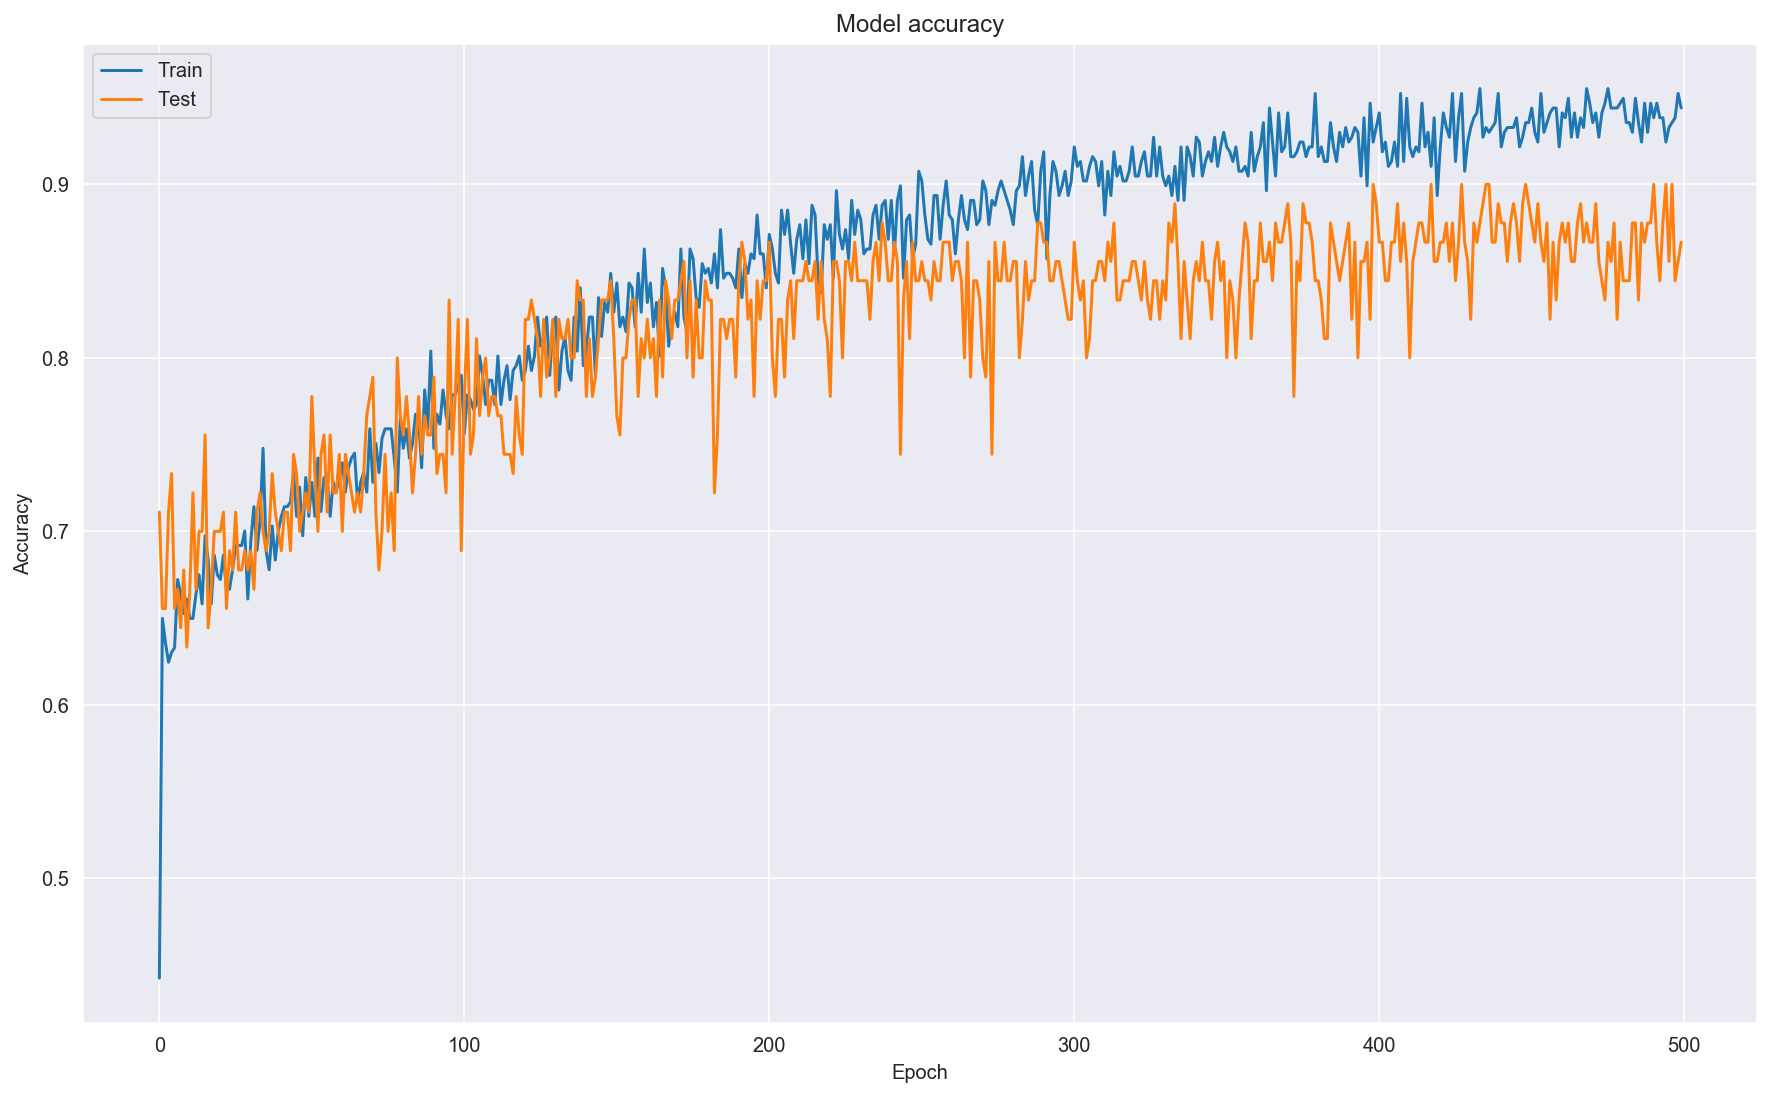

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

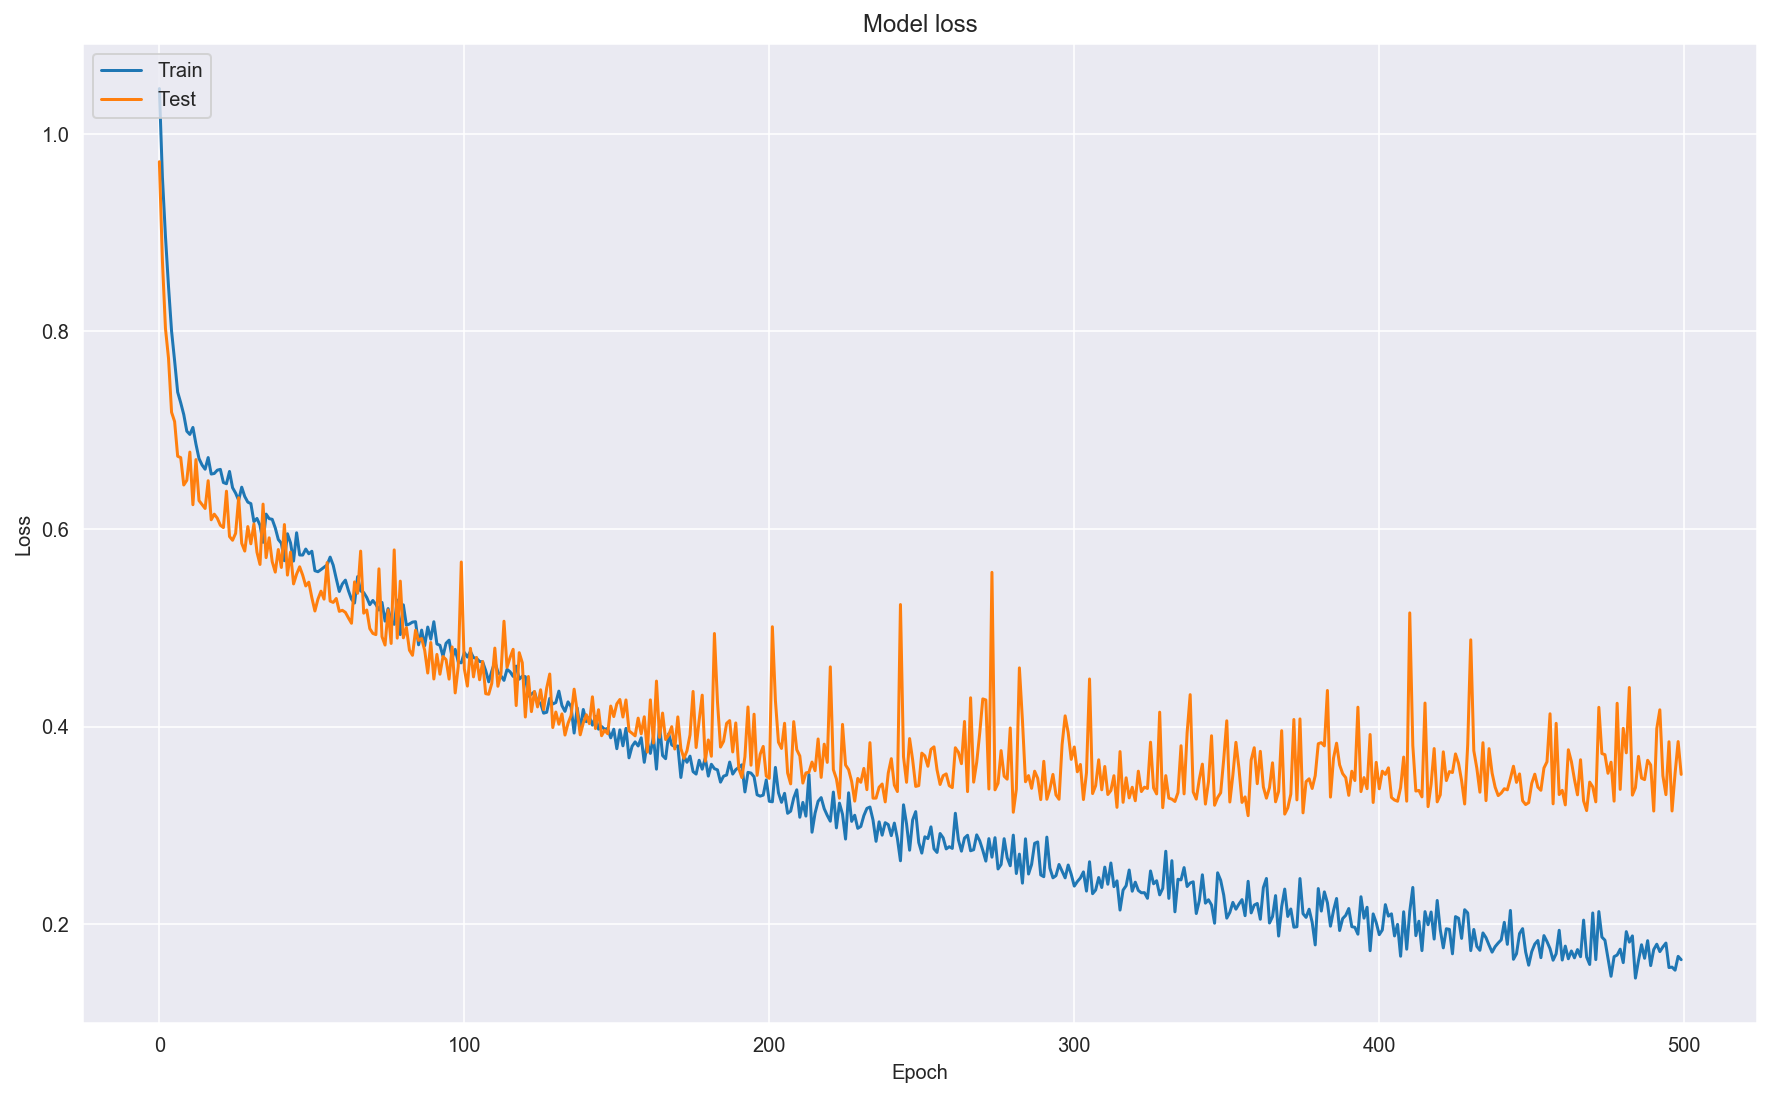

In [15]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [16]:
target_names = ['most likely', 'probable', 'least likely']
keras.fit(X_train_boruta, Y_train_boruta)
predictions = list(keras.predict(X_test_boruta))
print(classification_report(Y_test_boruta, predictions, target_names=target_names))

              precision    recall  f1-score   support

 most likely       0.68      0.81      0.74        31
    probable       0.46      0.46      0.46        26
least likely       0.89      0.73      0.80        33

    accuracy                           0.68        90
   macro avg       0.68      0.67      0.67        90
weighted avg       0.69      0.68      0.68        90

